# Mood Prediction Using Smartphone Data
### Data Mining Techniques | Vrije Universiteit Amsterdam | April 2024
##### Lieve Jilesen (ljn278), Ryan Ott (rot280), and Jaime Perez y Perez (jpz240) | Group 17

## 1 - Data Preparation

### 1.1 - Exploratory Data Analysis

#### Importing packages & loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
# sns.set(style="whitegrid")
# import statsmodels.api as sm

file_path = 'data/dataset_mood_smartphone.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col=0)
df

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


#### General data properties

In [2]:
num_records = df.shape[0]
num_participants = df.id.nunique()
num_days = df.time.dt.date.nunique()
num_variables = df.variable.nunique()

data_characteristics = {
    "Number of Records": [num_records],
    "Number of Participants": [num_participants],
    "Number of Days": [num_days],
    "Number of Variables": [num_variables],
}

data_characteristics_df = pd.DataFrame(data_characteristics)
data_characteristics_df

,Number of Records,Number of Participants,Number of Days,Number of Variables
0,376912,27,113,19


#### Variable properties

In [3]:
# Create a summary table for the dataset
summary_data = {
    "Variable": [],
    "Data Type": [],
    "Total Records": [],
    "Unique Values": [],
    "Missing Values": [],
    "Mean": [],
    "Std": [],
    "Min": [],
    "25%": [],
    "50%": [],
    "75%": [],
    "Max": []
}

for var in df.variable.unique():
    var_data = df[df['variable'] == var]['value']
    desc = var_data.describe()
    summary_data["Variable"].append(var)
    summary_data["Data Type"].append(df[df['variable'] == var]['value'].dtype)
    summary_data["Total Records"].append(var_data.count())
    summary_data["Unique Values"].append(var_data.nunique())
    summary_data["Missing Values"].append(df[df['variable'] == var]['value'].isnull().sum())
    summary_data["Mean"].append(desc['mean'])
    summary_data["Std"].append(desc['std'])
    summary_data["Min"].append(desc['min'])
    summary_data["25%"].append(desc['25%'])
    summary_data["50%"].append(desc['50%'])
    summary_data["75%"].append(desc['75%'])
    summary_data["Max"].append(desc['max'])

summary_table = pd.DataFrame(summary_data)
summary_table


,Variable,Data Type,Total Records,Unique Values,Missing Values,Mean,Std,Min,25%,50%,75%,Max
0,mood,float64,5641,10,0,6.992555,1.032769,1.000,7.00000,7.000000,8.000000,10.000
1,circumplex.arousal,float64,5597,5,46,-0.098624,1.051868,-2.000,-1.00000,0.000000,1.000000,2.000
2,circumplex.valence,float64,5487,5,156,0.687808,0.671298,-2.000,0.00000,1.000000,1.000000,2.000
3,activity,float64,22965,1868,0,0.115958,0.186946,0.000,0.00000,0.021739,0.158333,1.000
4,screen,float64,96578,64646,0,75.335206,253.822497,0.035,5.32225,20.044500,62.540250,9867.007
5,call,float64,5239,1,0,1.000000,0.000000,1.000,1.00000,1.000000,1.000000,1.000
6,sms,float64,1798,1,0,1.000000,0.000000,1.000,1.00000,1.000000,1.000000,1.000
7,appCat.builtin,float64,91288,23237,0,18.538262,415.989243,-82798.871,2.02000,4.038000,9.922000,33960.246
8,appCat.communication,float64,74276,39890,0,43.343792,128.912750,0.006,5.21800,16.225500,45.475750,9830.777
9,appCat.entertainment,float64,27125,12575,0,37.576480,262.960476,-0.011,1.33400,3.391000,14.922000,32148.677


#### Any records missing id or time?

In [4]:
# Do we have any records without index, id or time?
df[df['id'].isnull() | df['time'].isnull()]

,id,time,variable,value


No, thankfully not.

#### Distribution of mood scores

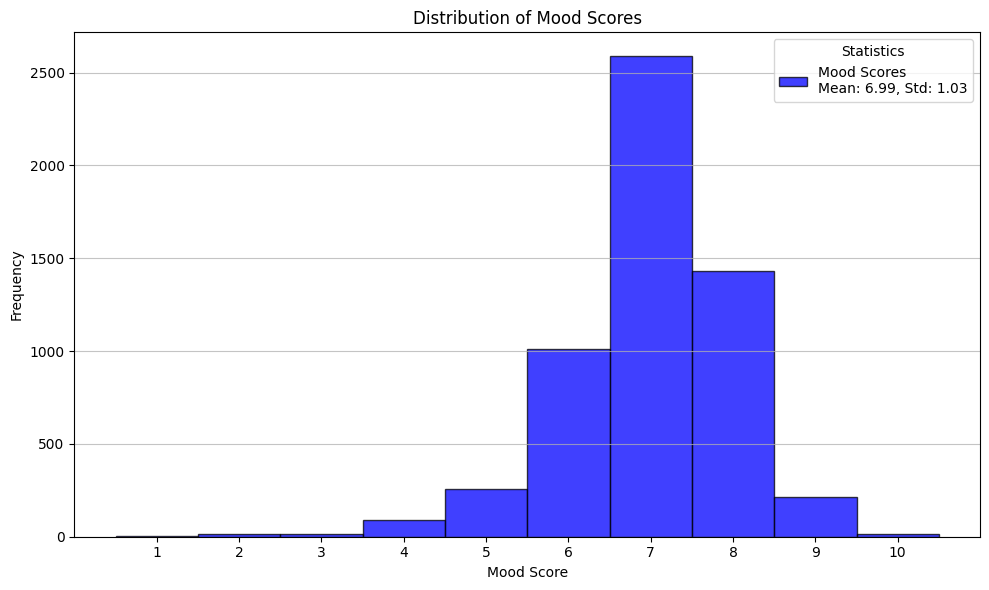

In [5]:
# Distribution of Mood Scores
mood_data = df[df['variable'] == 'mood']['value']
mean = mood_data.mean()
std = mood_data.std()

plt.figure(figsize=(10, 6))
# Plotting the histogram with adjusted bins to align with integer mood scores
n, bins, patches = plt.hist(mood_data.dropna(), bins=[i-0.5 for i in range(1, 12)], alpha=0.75, color='blue', edgecolor='black', label='Mood Scores')

# Adding legend with mean and std
plt.title('Distribution of Mood Scores')
plt.xlabel('Mood Score')
plt.ylabel('Frequency')
plt.xticks(range(1, 11))
plt.grid(axis='y', alpha=0.75)
legend_label = f"Mean: {mean:.2f}, Std: {std:.2f}"
plt.legend([f"Mood Scores\n{legend_label}"], loc='upper right', title='Statistics', frameon=True)
plt.tight_layout()
plt.show()

Histogram showing the distribution of possible mood scores in our dataset. The mood of participants seems to be normally distributed with a mean and standard deviation of around 7 and 1 respectively.

#### Mood for a participant

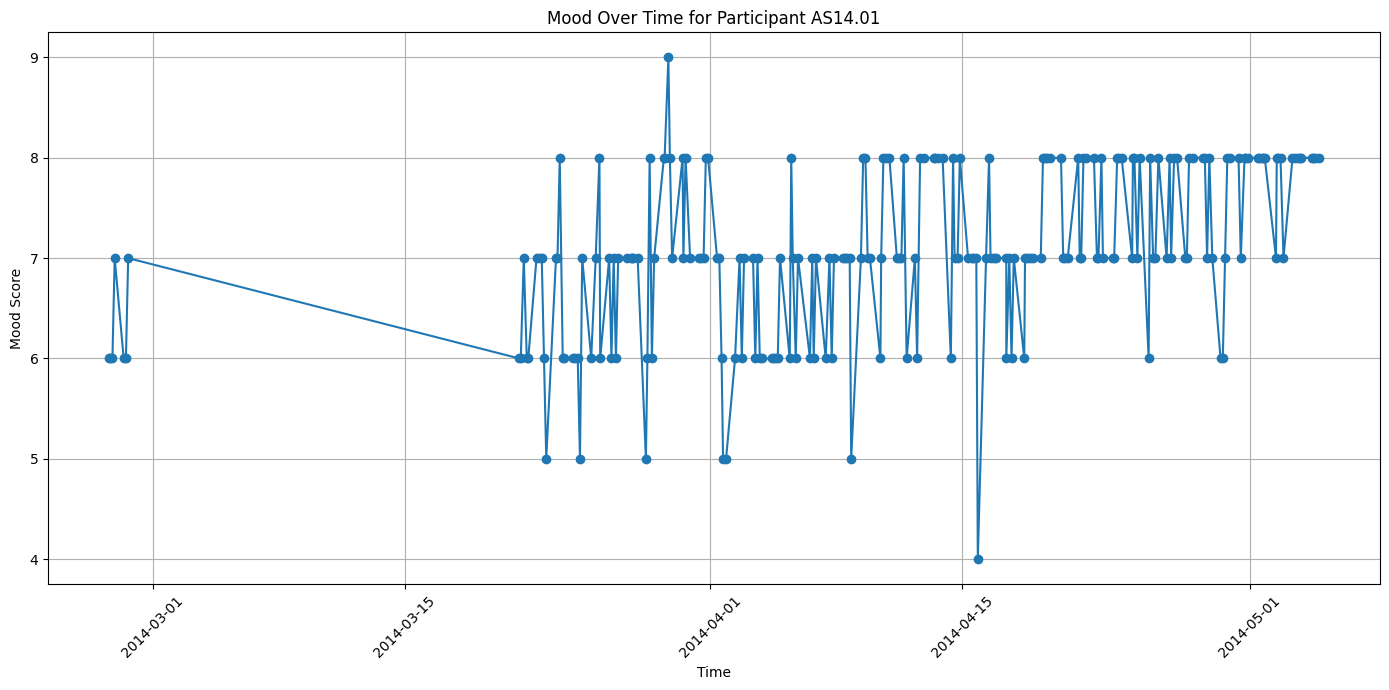

In [6]:
# Time Series of Mood for a Selected Participant
participant_data = df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')]
plt.figure(figsize=(14, 7))
plt.plot(participant_data['time'], participant_data['value'], marker='o', linestyle='-')
plt.title('Mood Over Time for Participant AS14.01')
plt.xlabel('Time')
plt.ylabel('Mood Score')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Timeseries plot of the mood scores given by the first participant. We see it being around 7 +- 1 for most of the time, with rare moments of extreme emotions. We also see long gaps in the record availability.

#### Correlation map for variables

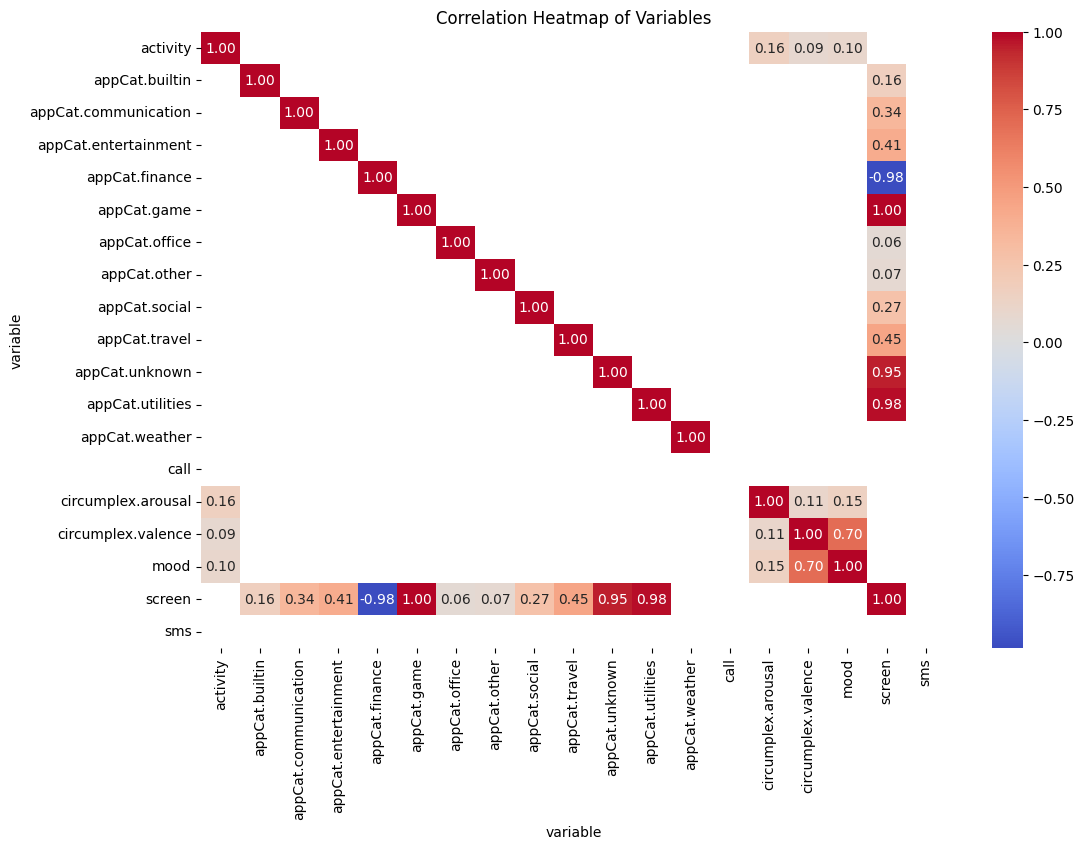

In [7]:
# Correlation heatmap of variables
pivot_table = df.pivot_table(index=['id', 'time'], columns='variable', values='value')
correlation_matrix = pivot_table.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Variables')
plt.show()

Correlation heatmap to visualize the correlation between different variables in the dataset. The heatmap provides a color-coded representation of the correlation values, with warmer colors indicating stronger positive correlations and cooler colors indicating stronger negative correlations. (Call is not visible as its boolean and only recorded when a call takes place so it always has a value of 1).

Arousal, and especially valence seem to be highly positively corellated with mood for example, while using finance apps seems to highly negatively correlate with screen time, which could be useful features to consider when making new predictions.

#### Activity & mood relationship

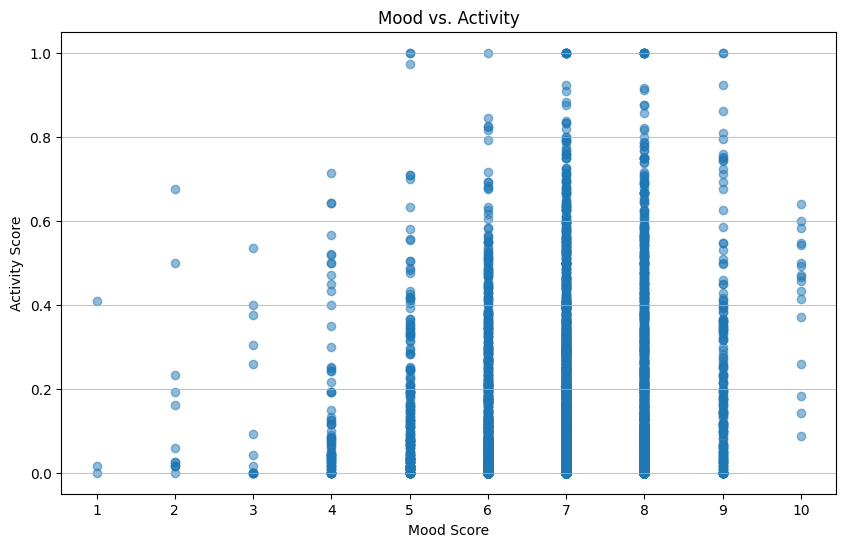

In [8]:
# Activity and Mood Relationship
activity_data = df[df['variable'] == 'activity']
mood_data = df[df['variable'] == 'mood']

# Merging on ID and Time for direct comparison
activity_mood_merged = pd.merge(activity_data, mood_data, on=['id', 'time'], suffixes=('_activity', '_mood'))

plt.figure(figsize=(10, 6))
plt.scatter(activity_mood_merged['value_mood'], activity_mood_merged['value_activity'], alpha=0.5)
plt.title('Mood vs. Activity')
plt.xlabel('Mood Score')
plt.ylabel('Activity Score')
plt.xticks(range(1, 11))
plt.grid(axis='y', alpha=0.75)
plt.show()

Plot showing co-occurence of mood with activiy scores. If the mood is in the common range of 7±1 we see participants record a wide range of activity scores, while if the mood is low, there is no high activity. 

### 1.2 - Data Cleaning (Still w.i.p. ryan)

#### Adapting datatypes

Because call and sms are boolean (only present if true) we convert them to boolean values.

In [9]:
# Convert 'call' and 'sms' data to boolean
for variable in ['call', 'sms']:
    df.loc[df['variable'] == variable, 'value'] = df[df['variable'] == variable]['value'].fillna(0).astype(bool)

/var/folders/gm/j6b9d4fx06q0g89jjy_7y21w0000gn/T/ipykernel_77644/3437957870.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['variable'] == variable, 'value'] = df[df['variable'] == variable]['value'].fillna(0).astype(bool)
/var/folders/gm/j6b9d4fx06q0g89jjy_7y21w0000gn/T/ipykernel_77644/3437957870.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[df['variable'] == variable, 'value'] = df[df['variable'] == variable]['value'].fillna(0).astype(bool)


#### Removing incorrect values

Because all `appCat.*` variables and `screen` should denote a time duration, they cannot be negative. Thus, any records with negative duration must be incorrect and removed. We see this is the case for example when looking at the variables properties table under section 1.1, where the min value for `appCat.builtin` is highly negative.

In [10]:
# List of variables denoting time durations
time_variables = [var for var in df['variable'].unique() if 'appCat.' in var or var == 'screen']

# Remove records with negative durations for specified variables
initial_count = df.shape[0]
for var in time_variables:
    before_count = df[df['variable'] == var].shape[0]
    df = df[~((df['variable'] == var) & (df['value'] < 0))]
    after_count = df[df['variable'] == var].shape[0]
    print(f"Removed {before_count - after_count} records from {var} due to negative values.")

total_removed = initial_count - df.shape[0]
print(f"Total records removed: {total_removed}")

Removed 0 records from screen due to negative values.
Removed 3 records from appCat.builtin due to negative values.
Removed 0 records from appCat.communication due to negative values.
Removed 1 records from appCat.entertainment due to negative values.
Removed 0 records from appCat.finance due to negative values.
Removed 0 records from appCat.game due to negative values.
Removed 0 records from appCat.office due to negative values.
Removed 0 records from appCat.other due to negative values.
Removed 0 records from appCat.social due to negative values.
Removed 0 records from appCat.travel due to negative values.
Removed 0 records from appCat.unknown due to negative values.
Removed 0 records from appCat.utilities due to negative values.
Removed 0 records from appCat.weather due to negative values.
Total records removed: 4


#### Removing extreme values (Todo, Ryan)

In [11]:
# # Outlier removal and reporting
# outlier_report = []
# for var in df.variable.unique():
#     if df[df['variable'] == var]['value'].dtype in ['float64', 'int64']:  # Ensure we're only looking at numeric data
#         var_data_before = df[df['variable'] == var]['value']
#         Q1 = var_data_before.quantile(0.25)
#         Q3 = var_data_before.quantile(0.75)
#         IQR = Q3 - Q1
#         condition = ~((df['variable'] == var) & ((df['value'] < (Q1 - 1.5 * IQR)) | (df['value'] > (Q3 + 1.5 * IQR))))
#         removed = df[condition].shape[0]
#         df = df[condition]
#         var_data_after = df[df['variable'] == var]['value']
#         outlier_report.append({
#             'Variable': var,
#             'Removed Outliers': var_data_before.shape[0] - var_data_after.shape[0],
#             'Remaining Data': var_data_after.shape[0]
#         })

# outlier_report_df = pd.DataFrame(outlier_report)
# print(outlier_report_df)

Empty DataFrame
Columns: []
Index: []


#### Imputing missing values (Todo, Ryan)

# Old code (I think Lieve's :))

In [ ]:
# clean data by dropping NA values

cleaned_data = df[df['value'] != 'NA'].dropna()

# TODO: remove outliers for each variable and write in report why/how

print(cleaned_data)

In [ ]:
# Histogram of mood 
plt.figure(figsize=(8, 6))
plt.hist(cleaned_data[cleaned_data['variable'] == 'mood']['value'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Mood')
plt.xlabel('Mood')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Boxplot of arousal 
plt.figure(figsize=(8, 6))
plt.boxplot(cleaned_data[cleaned_data['variable'] == 'circumplex.arousal']['value'], vert=True)
plt.title('Boxplot of arousal')
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of valence 
plt.figure(figsize=(8, 6))
plt.boxplot(cleaned_data[cleaned_data['variable'] == 'circumplex.valence']['value'], vert=True)
plt.title('Boxplot of valence')
plt.grid(True)
plt.tight_layout()
plt.show()

# Time series plot of mood
# TODO: fix errors and readability of plot
grouped_data = cleaned_data.groupby('id')

# Plot for each 'id'
plt.figure(figsize=(30, 6))
for name, group in grouped_data:
    plt.plot(group[cleaned_data['variable'] == 'mood']['time'], group[cleaned_data['variable'] == 'mood']['value'], label=name, linewidth=1)
    # plt.plot(group['time'], group['value'], label=name, linewidth=1)
    # plt.plot(cleaned_data[cleaned_data['variable'] == 'mood']['time'], cleaned_data[cleaned_data['variable'] == 'mood']['value'], linewidth=1)

plt.title('Time Series Plot of Mood')
plt.xlabel('Time')
plt.ylabel('Mood')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Time series of activity
# TODO: fix errors and readability of plot
grouped_data = cleaned_data.groupby('id')

# Plot for each 'id'
plt.figure(figsize=(30, 6))
for name, group in grouped_data:
    plt.plot(group[cleaned_data['variable'] == 'activity']['time'], group[cleaned_data['variable'] == 'activity']['value'], label=name, linewidth=1)
    # plt.plot(group['time'], group['value'], label=name, linewidth=1)
    # plt.plot(cleaned_data[cleaned_data['variable'] == 'mood']['time'], cleaned_data[cleaned_data['variable'] == 'mood']['value'], linewidth=1)

plt.title('Time Series Plot of Activity')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time series of activity AND mood

avg_activity = cleaned_data[cleaned_data['variable'] == 'activity'].groupby(cleaned_data['time'].dt.date)['value'].mean()
avg_mood = cleaned_data[cleaned_data['variable'] == 'mood'].groupby(cleaned_data['time'].dt.date)['value'].mean()

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('Time')
ax1.set_ylabel('Activity', color='tab:red')
ax1.plot(avg_activity.index, avg_activity.values, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Mood', color='tab:blue')
ax2.plot(avg_mood.index, avg_mood.values, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.show()

# Time series of screen AND mood
avg_screen = cleaned_data[cleaned_data['variable'] == 'screen'].groupby(cleaned_data['time'].dt.date)['value'].mean()

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('Time')
ax1.set_ylabel('screen', color='tab:red')
ax1.plot(avg_screen.index, avg_screen.values, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Mood', color='tab:blue')
ax2.plot(avg_mood.index, avg_mood.values, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.show()

# Time series of utilities app and mood
avg_ut = cleaned_data[cleaned_data['variable'] == 'appCat.utilities'].groupby(cleaned_data['time'].dt.date)['value'].mean()

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.set_xlabel('Time')
ax1.set_ylabel('Utilities', color='tab:red')
ax1.plot(avg_ut.index, avg_ut.values, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Mood', color='tab:blue')
ax2.plot(avg_mood.index, avg_mood.values, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout() 
plt.show()

In [ ]:
# convert to pandas dataframe
df = pd.DataFrame(cleaned_data, columns=["", "id", "time", "variable", "value"])

groups = df.groupby('variable')['value']

# TODO: fix statisitcal test so we can remove varaibles which are not significant

# Perform statistical tests for each variable
for var, group in groups:
    if var != 'mood':
        if len(group.unique()) > 2: 
            f_statistic, p_value = stats.f_oneway(*[group for name, group in groups])
            if p_value < 0.05:
                print(f"Variable '{var}' is significant (p-value: {p_value:.4f}, f stat: {f_statistic})")
            else:
                print(f"Variable '{var}' is not significant (p-value: {p_value:.4f}, f stat: {f_statistic})")